# Classifiy people as good or bad credit risks.
Uses the German Credit dataset
Dataset Link: https://www.openml.org/search?type=data&sort=runs&id=31&status=active

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

from credit_g_dataset import get_preprocessed_credit_g_dataset

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 6)

# Load and pre-process version 1 of the dataset credit-g

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
    checking_status  duration                  credit_history    purpose  \
0                <0         6  critical/other existing credit   radio/tv   
1          0<=X<200        48                   existing paid   radio/tv   
2       no checking        12  critical/other existing credit  education   
..              ...       ...                             ...        ...   
997     no checking        12                   existing paid   radio/tv   
998              <0        45                   existing paid   radio/tv   
999        0<=X<200        45  critical/other existing credit   used car   

     credit_amount    savings_status  employment  installment_commitment  \
0             1169  no known savings         >=7                       4   
1             5951              <100      1<=X<4                       2   
2             2096              <100      4<=X<7                       2   
..           

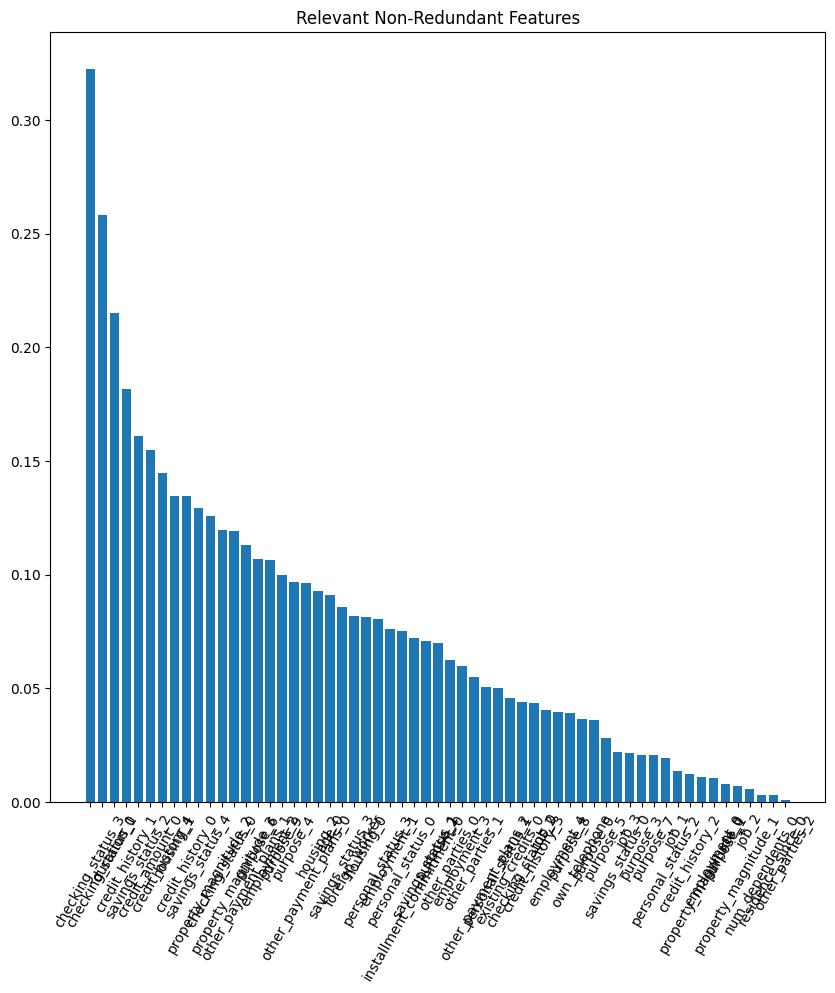

X_train type:  <class 'pandas.core.frame.DataFrame'>
X_train Shape:  (900, 59)
y_train type:  <class 'numpy.ndarray'>
y_train Shape:  (900,)


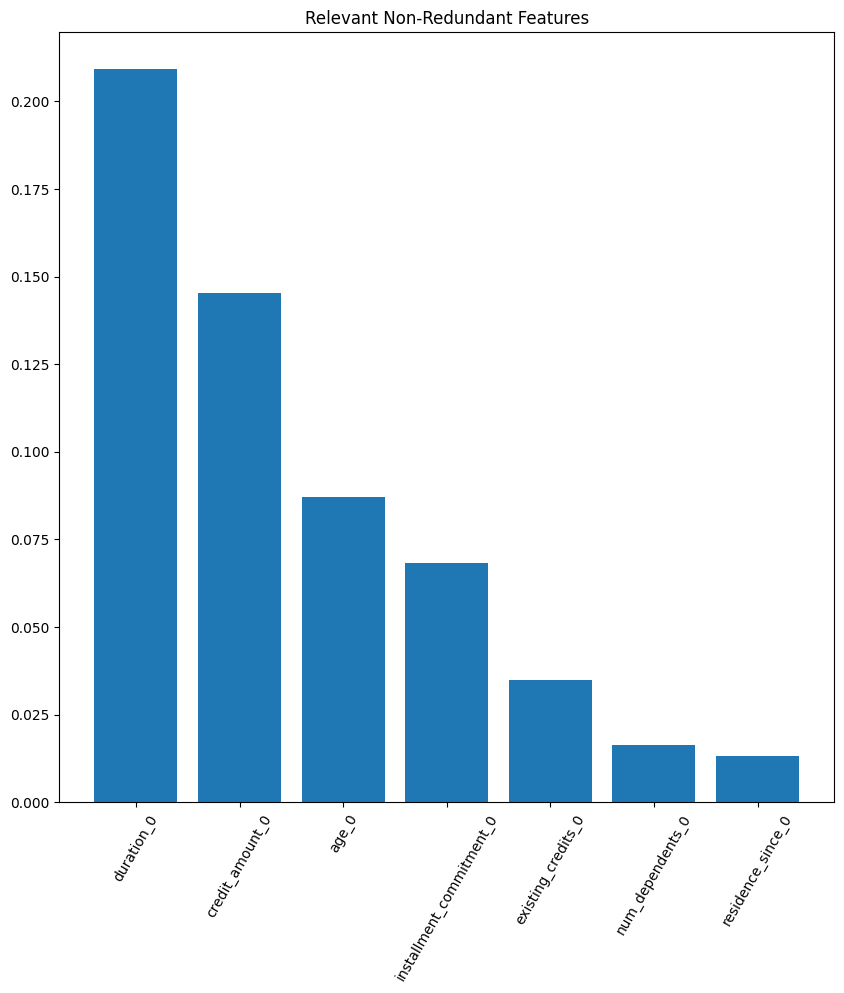

Total Nr. of numeric Features:  7
Nr. of selected numeric Features:  7
Relevant and non-redundant numerical features: ['duration_0' 'credit_amount_0' 'age_0' 'installment_commitment_0'
 'existing_credits_0' 'num_dependents_0' 'residence_since_0']


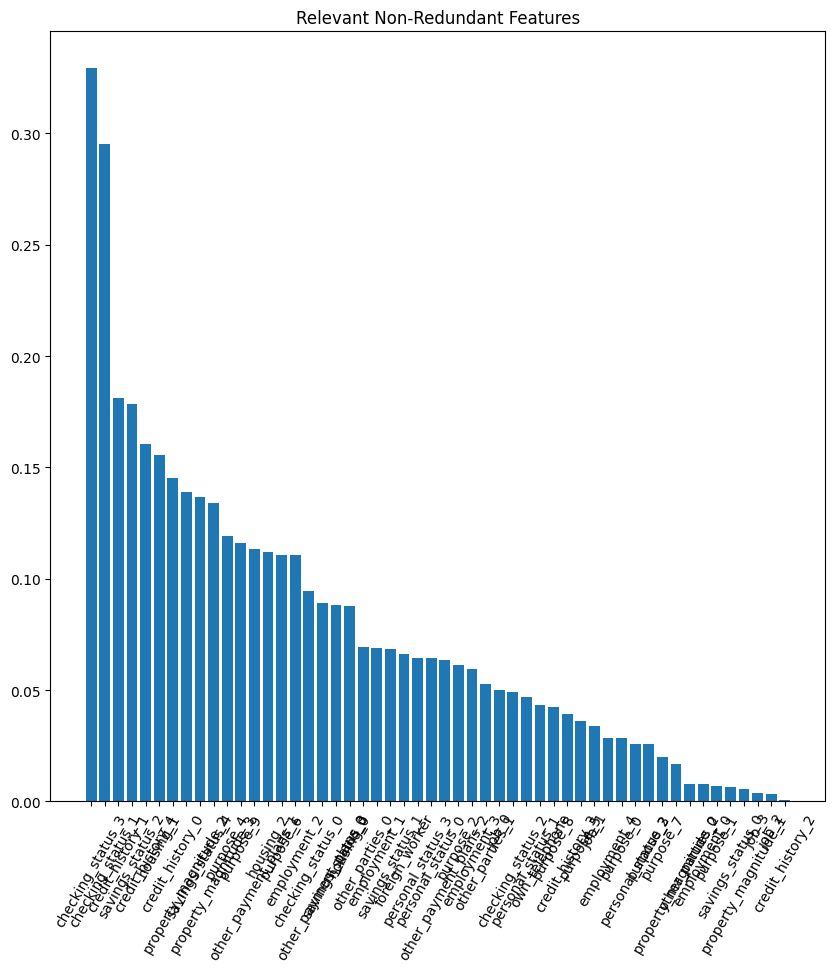

Total Nr. of categorical features:  52
Nr. of selected categorical Features:  52
Relevant and non-redundant categorical features: ['duration_0' 'credit_amount_0' 'age_0' 'installment_commitment_0'
 'existing_credits_0' 'num_dependents_0' 'residence_since_0']
All selected features: ['duration_0', 'credit_amount_0', 'age_0', 'installment_commitment_0', 'existing_credits_0', 'num_dependents_0', 'residence_since_0', 'checking_status_3', 'checking_status_1', 'credit_history_1', 'savings_status_2', 'credit_history_4', 'housing_1', 'credit_history_0', 'property_magnitude_2', 'savings_status_4', 'property_magnitude_3', 'purpose_4', 'purpose_9', 'other_payment_plans_1', 'housing_2', 'purpose_6', 'employment_2', 'checking_status_0', 'other_payment_plans_0', 'savings_status_3', 'housing_0', 'other_parties_0', 'employment_1', 'savings_status_1', 'foreign_worker', 'personal_status_3', 'personal_status_0', 'other_payment_plans_2', 'purpose_2', 'employment_3', 'other_parties_1', 'job_0', 'checking_st

In [2]:
#%%capture
X_train, X_validation, X_test, y_train, y_validation, y_test = get_preprocessed_credit_g_dataset()

## Train the model using the training set and adjust hyperparameters with Optuna using the validation set

In [3]:
random_state = 0

In [4]:
def objective(trial, X_train, X_validation, y_train, y_validation):   
    params = {
    "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
    "splitter": trial.suggest_categorical("splitter", ["best", "random"]),
    "max_depth": trial.suggest_int("max_depth", 1, 10),
    "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
    "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
    "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),    
    "random_state": random_state,
    }
    
    model = DecisionTreeClassifier(**params).fit(X_train, y_train)

    y_predicted = model.predict(X_validation)   
    (tn, fp, fn, tp) = confusion_matrix(y_validation, y_predicted).ravel()
    f1_val = (2*tp)/(2*tp+fp+fn)
    
    return f1_val


In [5]:
start_time = time.time()

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction = "maximize")
func = lambda trial: objective(trial, X_train, X_validation, y_train, y_validation)

# Start optimizing with 100 trials
study.optimize(func, n_trials = 100)

total_time = time.time()-start_time
print(f"total_time={total_time}")
print(study.best_params)
print(study.best_value)

total_time=1.912055253982544
{'criterion': 'gini', 'splitter': 'random', 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 'sqrt'}
0.8306264501160093


In [6]:
best_trial = study.best_trial
print("  Value: {}".format(best_trial.value))
print("Number of finished trials: ", len(study.trials))
print(f"Best trial: {best_trial.number}")
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

  Value: 0.8306264501160093
Number of finished trials:  100
Best trial: 20
  Params: 
    criterion: gini
    splitter: random
    max_depth: 6
    min_samples_split: 5
    min_samples_leaf: 7
    max_features: sqrt


## Run on the test set and use training and validation sets for training

In [7]:
X_train_valid = np.concatenate((X_train, X_validation))
y_train_valid = np.concatenate((y_train, y_validation))

model = DecisionTreeClassifier(**best_trial.params).fit(X_train_valid, y_train_valid)

y_predicted = model.predict(X_test)

(tn, fp, fn, tp) = confusion_matrix(y_test, y_predicted).ravel()
precision_val = float(tp)/float(tp+fp)
recall_val = float(tp)/float(tp+fn)
specificity_val = float(tn)/float(tn+fp)
accuracy_val = float(tp+tn)/float(tn+fp+fn+tp)
f1_val = (2*tp)/(2*tp+fp+fn)
mcc_val = float((tp*tn)-(fp*fn))/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


print("\n")
print("Test set precision_val =", precision_val)
print("Test set recall_val =", recall_val)
print("Test set specificity =", specificity_val)
print("Test set mcc_val =", mcc_val)
print("Test set accuracy_val =", accuracy_val)
print("Test set f1_val =", f1_val)



Test set precision_val = 0.797752808988764
Test set recall_val = 0.9466666666666667
Test set specificity = 0.28
Test set mcc_val = 0.31368730865817757
Test set accuracy_val = 0.78
Test set f1_val = 0.8658536585365854


In [8]:
confusion_matrix(y_test, y_predicted)

array([[ 7, 18],
       [ 4, 71]], dtype=int64)

In [9]:
y_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1])